In [364]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

array = 'homer' #homer, kodiak
deployment = 'd2' #d1, d2
###PULL IN DATA FROM FAIRFIELD-------------------------------------------
path  = '/Users/cadequigley/Downloads/'+array+'_d1_fairfield_metadata.csv'

df = pd.read_csv(path)

###PULL IN DATA FROM DEPLOYMENT-------------------------------------------
#path2 = '/Users/cadequigley/Downloads/'+array+'_array_locations.csv'
path2 = '/Users/cadequigley/Downloads/'+array+'_array_install_'+deployment+'.csv'
df2 = pd.read_csv(path2)
if deployment == 'd1':
    df2 = df2[:-2] #removes nan rows
else:
    df2 = df2

handheld = df2['handheld_name'].to_numpy()
temp = []
for i in range(len(handheld)):
    temp.append(int(handheld[i]))

df2['Point #'] = temp
comb = pd.merge(df, df2, on='Point #', how='inner')
comb = comb.sort_values(by='mike_name')

###PULL IN DATA FROM MSEEDS-------------------------------------------
ah = pd.read_csv('/Users/cadequigley/Downloads/Research/deployment_array_design/'+array+'_mseed_completeness.csv') #contains start/end times
if deployment == 'd2':
    ah = ah[ah["start_mseed_d2"] != '0'] #dropping HM06 during second deployment since it has no data
ah = ah.rename(columns={"station": "Point #"})
comb = pd.merge(comb, ah, on='Point #', how='inner')
comb = comb.sort_values(by='mike_name')

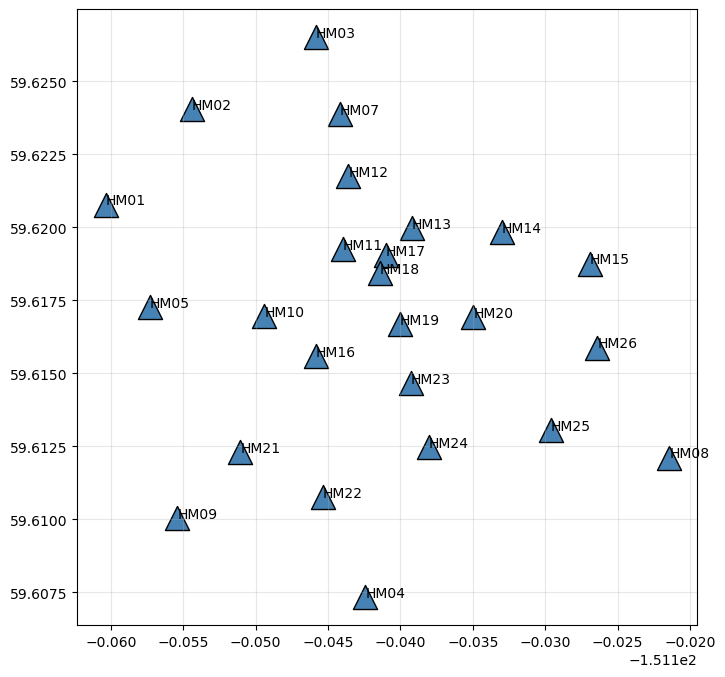

In [365]:
fig,ax = plt.subplots(figsize = (8,8))
x = comb['RU Position Longitude'].to_numpy()
y = comb['RU Position Latitude'].to_numpy()
#labels = comb['Point #'].to_numpy()
labels = comb['mike_name'].to_numpy()
ax.scatter(x, y, color = 'steelblue',marker = '^', linewidths = 1, s = 300,  edgecolors = 'black')

for i in range(len(labels)):
    ax.text(x[i],y[i], str(labels[i]))

ax.grid(alpha = 0.3)
plt.show()

In [366]:
latitudes = comb['RU Position Latitude'].to_numpy() #node determined latitude
longitudes = comb['RU Position Longitude'].to_numpy() #node determined longitude
elevations = comb['elevation'].to_numpy() #phone elevation, no RU elevation
start_times = comb['start_mseed_'+deployment].to_numpy()
end_times = comb['end_mseed_'+deployment].to_numpy()
stations = comb['mike_name'].to_numpy()
#serial_number = comb['Serial Number'].to_numpy()
serial_number = comb['node_serial'].to_numpy()
instrument_type = comb['instrument_type'].to_numpy()
channels_list = ['DHZ', 'DHN', 'DHE']
dips = [-90, 0, 0] #see fdsn description, https://docs.fdsn.org/projects/stationxml/en/latest/reference.html#dip
azimuths = [0,0,90] #see fdsn description, https://docs.fdsn.org/projects/stationxml/en/latest/reference.html#azimuth

In [367]:
import obspy
from obspy.core.inventory import Inventory, Network, Station, Channel, Site, Equipment
from obspy.clients.nrl import NRL

# By default this accesses the NRL online. Offline copies of the NRL can
# also be used instead

# The contents of the NRL can be explored interactively in a Python prompt,
# see API documentation of NRL submodule:
# http://docs.obspy.org/packages/obspy.clients.nrl.html
# Here we assume that the end point of data logger and sensor are already
# known:

if array == 'kodiak':
    array_name = 'Kodiak'
else:
    array_name = 'Homer'

###PULL IN REPONSE DATA (WILL BE SAME FOR ALL NODES)-------------------------------
nrl = NRL()
pre_amp_gain="18 dB (8)" 
sample_rate="250" 
phase_type="Linear Phase"
low_cut="Off"
sensor_keys = ["Magseis Fairfield", "Generation 2", "5 Hz"]
datalogger_keys = ["Magseis Fairfield", "Zland 1C or 3C", pre_amp_gain, sample_rate, phase_type, low_cut]
response = nrl.get_response(sensor_keys=sensor_keys, datalogger_keys=datalogger_keys)


# We'll first create all the various objects. These strongly follow the
# hierarchy of StationXML files.
inv = Inventory(
    # We'll add networks later.
    networks=[],
    # The source should be the id whoever create the file.
    source="Alaska Earthquake Center")

net = Network(
    # This is the network code according to the SEED standard.
    code="4E",
    selected_number_of_stations = len(stations),
    total_number_of_stations = len(stations),
    # A list of stations. We'll add one later.
    stations=[])
    #description="A test stations.")
    # Start-and end dates are optional.
    #start_date=obspy.UTCDateTime(2016, 1, 2))

for i in range(len(stations)):

    

    if instrument_type[i] == '3C':
        num_channels = 3
    else:
        num_channels = 1

        
    sta = Station(
    # This is the station code according to the SEED standard.
        code=stations[i],
        latitude=latitudes[i],
        longitude=longitudes[i],
        elevation=elevations[i],
        start_date=obspy.UTCDateTime(start_times[i]),
        end_date = obspy.UTCDateTime(end_times[i]),
        site=Site(name=array_name+", AK, USA"),
        selected_number_of_channels = num_channels,
        total_number_of_channels = num_channels,
        channels = []) #added this, see how it works
### Add equipment-----------------------------------------------
    equip = Equipment(
        description = 'Magseis Fairfield Zland '+instrument_type[i],
        serial_number = str(int(serial_number[i])),
        manufacturer = 'Magseis Fairfield',
        model = 'Zland '+instrument_type[i],
        installation_date = obspy.UTCDateTime(start_times[i]),
        removal_date = obspy.UTCDateTime(end_times[i])

    )

    
### Add first channel-----------------------------------------------
    
    cha1 = Channel(
        # This is the channel code according to the SEED standard.
        code=channels_list[0],
        # This is the location code according to the SEED standard.
        location_code="",
        # Note that these coordinates can differ from the station coordinates.
        latitude=latitudes[i],
        longitude=longitudes[i],
        elevation=elevations[i],
        start_date=obspy.UTCDateTime(start_times[i]),
        end_date = obspy.UTCDateTime(end_times[i]),
        depth=0.0,
        azimuth=azimuths[0],
        dip=dips[0],
        #sensor= Sensor(description = "Magseis Fairfield Zland 3C"),
        sample_rate=250)
        #description = sensor{"Magseis Fairfield"})

    cha1.sensor = equip
    cha1.response = response
    sta.channels.append(cha1)

    if num_channels == 1:
        net.stations.append(sta) #append only vertical channel for 1C instruments
    else: #add horizontal channels
    
### Add second channel-----------------------------------------------
        cha2 = Channel(
        # This is the channel code according to the SEED standard.
            code=channels_list[1],
        # This is the location code according to the SEED standard.
            location_code="",
        # Note that these coordinates can differ from the station coordinates.
            latitude=latitudes[i],
            longitude=longitudes[i],
            elevation=elevations[i],
            start_date=obspy.UTCDateTime(start_times[i]),
            end_date = obspy.UTCDateTime(end_times[i]),
            depth=0.0,
            azimuth=azimuths[1],
            #sensor = 'Magseis Fairfield Zland 3C',
            dip=dips[1],
            sample_rate=250)

        cha2.sensor = equip
        cha2.response = response
        sta.channels.append(cha2)
    
### Add third channel-----------------------------------------------
        cha3 = Channel(
        # This is the channel code according to the SEED standard.
            code=channels_list[2],
        # This is the location code according to the SEED standard.
            location_code="",
        # Note that these coordinates can differ from the station coordinates.
            latitude=latitudes[i],
            longitude=longitudes[i],
            elevation=elevations[i],
            start_date=obspy.UTCDateTime(start_times[i]),
            end_date = obspy.UTCDateTime(end_times[i]),
            depth=0.0,
            azimuth=azimuths[2],
            dip=dips[2],
            sample_rate=250)

   
        cha3.sensor = equip    
        cha3.response = response
        sta.channels.append(cha3)

    

        net.stations.append(sta)

inv.networks.append(net)

# And finally write it to a StationXML file. We also force a validation against
# the StationXML schema to ensure it produces a valid StationXML file.
#
# Note that it is also possible to serialize to any of the other inventory
# output formats ObsPy supports.
inv.write(array+"_"+deployment+"_flipped_station.xml", format="stationxml", validate=True)
print('inv written')

inv written


/var/folders/rg/vbnq7_qj6ks5m0l7cnnw46y00000gn/T/ipykernel_54142/214393953.py:20: ObsPyDeprecationWarning: 
        DEPRECATED

        Direct access to online NRL is deprecated as it will stop working when
        the original NRLv1 gets taken offline (Spring 2023), please consider
        working locally with a downloaded full copy of the old NRLv1 or new
        NRLv2 following instructions on the
        `NRL landing page <https://ds.iris.edu/ds/nrl/>`_.
        
  nrl = NRL()


### The output files all had issues with units in the response. In text editor, replace "COUNTS" with "counts" and "M/S" with "m/s"

In [344]:
inv[0][0][0]

Channel 'DHZ', Location '' 
	Time range: 2025-09-07T23:32:56.428000Z - 2025-10-12T07:47:56.424000Z
	Latitude: 59.6208, Longitude: -151.1604, Elevation: 44.0 m, Local Depth: 0.0 m
	Azimuth: 0.00 degrees from north, clockwise
	Dip: -90.00 degrees down from horizontal
	Sampling Rate: 250.00 Hz
	Sensor (Description): None (Magseis Fairfield Zland 3C)
	Response information available

In [172]:
inv[0][0][0]

Channel 'DHZ', Location '' 
	Time range: 2025-09-13T21:18:44.316000Z - 2025-10-15T18:42:44.312000Z
	Latitude: 57.4435, Longitude: -152.3685, Elevation: 69.0 m, Local Depth: 0.0 m
	Azimuth: 0.00 degrees from north, clockwise
	Dip: 90.00 degrees down from horizontal
	Sampling Rate: 250.00 Hz
	Response information available

In [358]:
inv2[0][0][3]

Channel 'SHZ', Location '' 
	Time range: 2015-07-01T06:01:47.000000Z - 2016-03-27T11:19:21.000000Z
	Latitude: 53.7790, Longitude: -166.2131, Elevation: 63.0 m, Local Depth: 0.0 m
	Azimuth: 0.00 degrees from north, clockwise
	Dip: 90.00 degrees down from horizontal
	Channel types: GEOPHYSICAL
	Sampling Rate: 50.00 Hz
	Sensor (Description): None (Mark Products L22/Reftek 130 Datalogger)
	Response information available

In [362]:
inv2[0][3][2]

Channel 'BHZ', Location '' 
	Time range: 2015-07-01T23:27:43.000000Z - 2016-07-29T21:58:55.000000Z
	Latitude: 53.7763, Longitude: -166.2194, Elevation: 133.5 m, Local Depth: 0.0 m
	Azimuth: 0.00 degrees from north, clockwise
	Dip: -90.00 degrees down from horizontal
	Channel types: GEOPHYSICAL
	Sampling Rate: 50.00 Hz
	Sensor (Description): None (Guralp CMG3T/Reftek 130 Datalogger)
	Response information available

In [363]:
response

Channel Response
	From M/S (Velocity in Meters per Second) to COUNTS (Digital Counts)
	Overall Sensitivity: 613325 defined at 25.000 Hz
	7 stages:
		Stage 1: PolesZerosResponseStage from M/S to V, gain: 76.7
		Stage 2: ResponseStage from V to V, gain: 8
		Stage 3: CoefficientsTypeResponseStage from V to COUNTS, gain: 1000
		Stage 4: CoefficientsTypeResponseStage from COUNTS to COUNTS, gain: 1
		Stage 5: CoefficientsTypeResponseStage from COUNTS to COUNTS, gain: 1
		Stage 6: CoefficientsTypeResponseStage from COUNTS to COUNTS, gain: 1
		Stage 7: CoefficientsTypeResponseStage from COUNTS to COUNTS, gain: 1

In [360]:
inv2

Inventory created at 2026-01-30T22:20:17.464400Z
	Created by: IRIS WEB SERVICE: fdsnws-station | version: 1.1.52
		    http://service.iris.edu/fdsnws/station/1/query?starttime=2016-01-01...
	Sending institution: IRIS-DMC (IRIS-DMC)
	Contains:
		Networks (1):
			9C
		Stations (15):
			9C.3A01 (Unalaska,AK,USA)
			9C.3A02 (Unalaska,AK,USA)
			9C.3A03 (Unalaska,AK,USA)
			9C.3A04 (Unalaska,AK,USA)
			9C.3A05 (Unalaska,AK,USA)
			9C.3A06 (Unalaska,AK,USA)
			9C.3A07 (Unalaska,AK,USA)
			9C.3A08 (Unalaska,AK,USA)
			9C.3A09 (Unalaska,AK,USA)
			9C.3A10 (Unalaska,AK,USA)
			9C.3A11 (Unalaska,AK,USA)
			9C.3A12 (Unalaska,AK,USA)
			9C.3A13 (Unalaska,AK,USA)
			9C.3A14 (Unalaska,AK,USA)
			9C.3A15 (Unalaska,AK,USA)
		Channels (66):
			9C.3A01..LOG, 9C.3A01..SHZ, 9C.3A01..SH1, 9C.3A01..SH2, 
			9C.3A02..LOG, 9C.3A02..SHZ, 9C.3A02..SH1, 9C.3A02..SH2, 
			9C.3A03..LOG, 9C.3A03..SHZ, 9C.3A03..SH1, 9C.3A03..SH2, 
			9C.3A04..BHZ, 9C.3A04..BH1, 9C.3A04..BH2, 9C.3A04..LOG, 
			9C.3A04..VM1, 9C.3A04..

In [313]:
import xml.etree.ElementTree as ET
xml_file = './homer_d1_station.xml'
tree = ET.parse(xml_file)
root = tree.getroot()
for units in root.findall('.//Network//Station//Channel//Response//InstrumentSensitivity//InputUnits'):
    print(units.text)

In [317]:
tree

In [357]:
from obspy.clients.fdsn import Client
client = Client("IRIS")
NET = '9C'
STA = '3A*'
CHAN = '*'
LOC = '*'
START = '2016-01-01'
END = '2016-02-01'

inv2 = client.get_stations(network=NET, station=STA, channel=CHAN,
                              location=LOC, starttime=START,
                              endtime=END, level='channel')

In [312]:
response

Channel Response
	From M/S (Velocity in Meters per Second) to COUNTS (Digital Counts)
	Overall Sensitivity: 613325 defined at 25.000 Hz
	7 stages:
		Stage 1: PolesZerosResponseStage from M/S to V, gain: 76.7
		Stage 2: ResponseStage from V to V, gain: 8
		Stage 3: CoefficientsTypeResponseStage from V to COUNTS, gain: 1000
		Stage 4: CoefficientsTypeResponseStage from COUNTS to COUNTS, gain: 1
		Stage 5: CoefficientsTypeResponseStage from COUNTS to COUNTS, gain: 1
		Stage 6: CoefficientsTypeResponseStage from COUNTS to COUNTS, gain: 1
		Stage 7: CoefficientsTypeResponseStage from COUNTS to COUNTS, gain: 1

In [ ]:
#things that I might need to find
#clock_drift_in_seconds_per_sample
#sensor description
#How to save station xml information: one inventory for both deployments over whole thing;
#one inventory for each array; one inventory for first deployment, second for second deployment



In [163]:
inv[0][0][1]

Channel 'DHN', Location '' 
	Time range: 2025-09-13T21:18:44.316000Z - 2025-10-15T18:42:44.312000Z
	Latitude: 57.4435, Longitude: -152.3685, Elevation: 69.0 m, Local Depth: 0.0 m
	Azimuth: 0.00 degrees from north, clockwise
	Dip: 0.00 degrees down from horizontal
	Sampling Rate: 250.00 Hz
	Response information available

In [227]:
inv2[0][0][3].sensor

Equipment:
	Type: None
	Description: Mark Products L22/Reftek 130 Datalogger
	Manufacturer: None
	Vendor: None
	Model: None
	Serial number: None
	Installation date: None
	Removal date: None
	Resource id: None
	Calibration Dates:


In [87]:
comb.columns

Index(['RU Position X (ECEF)', 'RU Position Y (ECEF)', 'RU Position Z (ECEF)',
       'RU Position Latitude', 'RU Position Longitude', 'Easting (Final)',
       'Heigth (Final)', 'Northing (Final)', 'Northing (As Laid)',
       'Easting (As Laid)', 'Height (As Laid)', 'Line #', 'Point #',
       'Deployment Time', 'State', 'Part Number', 'Serial Number',
       'Actual Group', 'Sample Interval', 'Gain', 'Nyquist Filter (Hz)',
       'Lowcut Filter (Hz)', 'DC Offset Removal', 'Schedule',
       'Scheduled Start Time', 'Pickup Time', 'Acquisition Start Time',
       'Acquisition Stop Time', 'Deployment Device', 'Pickup Device',
       'Startup Impedance', 'Startup Resistance', 'Startup Sensitivity',
       'Startup Damping', 'Startup Natural Frequency',
       'Distance from Preplan (As Laid)', 'Distance from Preplan (Final)',
       'As Laid Latitude', 'As Laid Longitude', 'station_name_x',
       'handheld_name', 'mike_name', 'signficantly_moved', 'node_serial',
       'install_time_ak

In [ ]:
import obspy
from obspy.core.inventory import Inventory, Network, Station, Channel, Site
from obspy.clients.nrl import NRL


# We'll first create all the various objects. These strongly follow the
# hierarchy of StationXML files.
inv = Inventory(
    # We'll add networks later.
    networks=[],
    # The source should be the id whoever create the file.
    source="ObsPy-Tutorial")

net = Network(
    # This is the network code according to the SEED standard.
    code="XX",
    # A list of stations. We'll add one later.
    stations=[],
    description="A test stations.",
    # Start-and end dates are optional.
    start_date=obspy.UTCDateTime(2016, 1, 2))

sta = Station(
    # This is the station code according to the SEED standard.
    code="ABC",
    latitude=1.0,
    longitude=2.0,
    elevation=345.0,
    creation_date=obspy.UTCDateTime(2016, 1, 2),
    site=Site(name="First station"))

cha = Channel(
    # This is the channel code according to the SEED standard.
    code="HHZ",
    # This is the location code according to the SEED standard.
    location_code="",
    # Note that these coordinates can differ from the station coordinates.
    latitude=1.0,
    longitude=2.0,
    elevation=345.0,
    depth=10.0,
    azimuth=0.0,
    dip=-90.0,
    sample_rate=200)

# By default this accesses the NRL online. Offline copies of the NRL can
# also be used instead
nrl = NRL()
# The contents of the NRL can be explored interactively in a Python prompt,
# see API documentation of NRL submodule:
# http://docs.obspy.org/packages/obspy.clients.nrl.html
# Here we assume that the end point of data logger and sensor are already
# known:
response = nrl.get_response( # doctest: +SKIP
    sensor_keys=['Streckeisen', 'STS-1', '360 seconds'],
    datalogger_keys=['REF TEK', 'RT 130 & 130-SMA', '1', '200'])


# Now tie it all together.
cha.response = response
sta.channels.append(cha)
net.stations.append(sta)
inv.networks.append(net)

# And finally write it to a StationXML file. We also force a validation against
# the StationXML schema to ensure it produces a valid StationXML file.
#
# Note that it is also possible to serialize to any of the other inventory
# output formats ObsPy supports.

In [182]:
(84 - (-1*80))/8
np.linspace(84,-80, 21)

array([ 84. ,  75.8,  67.6,  59.4,  51.2,  43. ,  34.8,  26.6,  18.4,
        10.2,   2. ,  -6.2, -14.4, -22.6, -30.8, -39. , -47.2, -55.4,
       -63.6, -71.8, -80. ])

In [179]:
164/8

20.5

In [186]:
len(designators)

NameError: name 'designators' is not defined